# Core-core relationships in array compendium

This notebook performs the same stability analysis using the *P. aeruginosa* array compendium that is described in [Tan et al.](https://journals.asm.org/doi/10.1128/msystems.00025-15?permanently=true) and found in the associated repository [here](https://github.com/greenelab/adage/blob/master/Data_collection_processing/Pa_compendium_02.22.2014.pcl). This notebook then compares the most stable genes identified using the array compendium compared to the RNA-seq compendium to validate our results are robust across platform (positive control).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy.stats
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from scripts import utils, paths

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Params
most_percent = 0.05
least_percent = 0.05

In [3]:
# Output filenames
array_similarity_dist_filename = "array_similarity_scores_dist_spell.svg"

# Files containing genes with highest and lowest transcriptional similarity scores high and low
array_similarity_scores_filename = "array_similarity_scores_spell.tsv"

In [4]:
# Import correlation matrix
array_expression_filename = paths.ARRAY_COMPENDIUM_GE
array_metadata_filename = paths.ARRAY_COMPENDIUM_METADATA

array_expression = pd.read_csv(
    array_expression_filename, sep="\t", index_col=0, header=0
).T
array_metadata = pd.read_csv(array_metadata_filename, sep="\t", index_col=0, header=0)

In [5]:
print(array_expression.shape)
array_expression.head()

(950, 5549)


PA0001     PA0002    PA0003     PA0004  \
05_PA14000-4-2_5-10-07_S2.CEL  9.620090  10.575783  9.296287   9.870074   
54375-4-05.CEL                 9.327996  10.781977  9.169988  10.269239   
AKGlu_plus_nt_7-8-09_s1.CEL    9.368599  10.596248  9.714517   9.487155   
anaerobic_NO3_1.CEL            9.083292   9.897050  8.068471   7.310218   
anaerobic_NO3_2.CEL            8.854901   9.931392  8.167126   7.526595   

                                 PA0005    PA0006    PA0007     PA0008  \
05_PA14000-4-2_5-10-07_S2.CEL  8.512268  7.903954  7.039473  10.209826   
54375-4-05.CEL                 7.237999  7.663758  6.855194   9.631573   
AKGlu_plus_nt_7-8-09_s1.CEL    7.804147  7.681754  6.714411   9.497601   
anaerobic_NO3_1.CEL            6.723634  7.141148  8.492302   7.740717   
anaerobic_NO3_2.CEL            6.864015  7.154523  8.492109   7.716687   

                                 PA0009    PA0010  ...    PA5561    PA5562  \
05_PA14000-4-2_5-10-07_S2.CEL  9.784684  5.485688  ...  7.740609  9.730384   
54375-4-05.CEL                 9.404465  5.684067  ...  7.127736  9.687607   
AKGlu_plus_nt_7-8-09_s1.CEL    9.523126  5.766331  ...  7.343241  9.717993   
anaerobic_NO3_1.CEL            7.640251  5.267993  ...  7.374740  8.287819   
anaerobic_NO3_2.CEL            7.268094  5.427256  ...  7.425398  8.588969   

                                  PA5563     PA5564     PA5565    PA5566  \
05_PA14000-4-2_5-10-07_S2.CEL  10.516061  10.639916   9.746849  5.768592   
54375-4-05.CEL                 10.199612   9.457152   9.318372  5.523898   
AKGlu_plus_nt_7-8-09_s1.CEL    10.419979  10.164667  10.305005  5.806817   
anaerobic_NO3_1.CEL             9.437053   8.936576   9.418147  5.956482   
anaerobic_NO3_2.CEL             9.313851   8.684602   9.272818  5.729479   

                                 PA5567     PA5568     PA5569     PA5570  
05_PA14000-4-2_5-10-07_S2.CEL  9.224442  11.512176  12.529719  11.804896  
54375-4-05.CEL                 7.911031  10.828271  11.597643  11.268520  
AKGlu_plus_nt_7-8-09_s1.CEL    8.575730  10.858250  12.255953  11.309662  
anaerobic_NO3_1.CEL            7.481406   7.687985   9.205525   9.395773  
anaerobic_NO3_2.CEL            7.699086   7.414436   9.363494   9.424762  

[5 rows x 5549 columns]

In [6]:
print(array_metadata.shape)
array_metadata.head()

(1217, 17)


sample_name                ml_data_source  \
experiment                                                 
E-GEOD-46947  GSM1141730 1  GSM1141730_PA01_ZnO_PZO_.CEL   
E-GEOD-46947  GSM1141729 1  GSM1141729_PA01_none_PC_.CEL   
E-GEOD-65882  GSM1608059 1   GSM1608059_Planktonic_1.CEL   
E-GEOD-65882  GSM1608060 1   GSM1608060_Planktonic_2.CEL   
E-GEOD-65882  GSM1608061 1   GSM1608061_Planktonic_3.CEL   

                                                    description nucleic_acid  \
experiment                                                                     
E-GEOD-46947  Pseudomonas aeruginosa PAO1 LB aerated  5 h wi...          RNA   
E-GEOD-46947        Pseudomonas aeruginosa PAO1 LB aerated  5 h          RNA   
E-GEOD-65882                          PAO1 WT. Planktonic. Rep1          RNA   
E-GEOD-65882                          PAO1 WT. Planktonic. Rep2          RNA   
E-GEOD-65882                          PAO1 WT. Planktonic. Rep3          RNA   

                                  medium genotype    od growth_setting_1  \
experiment                                                                 
E-GEOD-46947                          LB      NaN   NaN       planktonic   
E-GEOD-46947                          LB      NaN   NaN       planktonic   
E-GEOD-65882  PBM plus 1 g / L glucose.        WT  0.26      Planktonic    
E-GEOD-65882  PBM plus 1 g / L glucose.        WT  0.26      Planktonic    
E-GEOD-65882  PBM plus 1 g / L glucose.        WT  0.26      Planktonic    

             growth_setting_2 strain  temperature               treatment  \
experiment                                                                  
E-GEOD-46947          aerated   PAO1         37.0  1 mM ZnO nanoparticles   
E-GEOD-46947          aerated   PAO1         37.0                     NaN   
E-GEOD-65882          Aerated   PAO1         37.0                     NaN   
E-GEOD-65882          Aerated   PAO1         37.0                     NaN   
E-GEOD-65882          Aerated   PAO1         37.0                     NaN   

                     additional_notes variant_phenotype abx_marker  \
experiment                                                           
E-GEOD-46947             Grown for 5h               NaN        NaN   
E-GEOD-46947             Grown for 5h               NaN        NaN   
E-GEOD-65882  Grown shaking at 200rpm               NaN        NaN   
E-GEOD-65882  Grown shaking at 200rpm               NaN        NaN   
E-GEOD-65882  Grown shaking at 200rpm               NaN        NaN   

             biotic_int_lv_2 biotic_int_lv_1  
experiment                                    
E-GEOD-46947             NaN             NaN  
E-GEOD-46947             NaN             NaN  
E-GEOD-65882             NaN             NaN  
E-GEOD-65882             NaN             NaN  
E-GEOD-65882             NaN             NaN

## Make PAO1, PA14 array compendia

In [7]:
# Set "ml_data_source" (which corresponds to the sample ids in our expression matrix) as the index
array_metadata.set_index("ml_data_source", inplace=True)

In [8]:
# Select and separate between samples that are using PAO1 strain and those using PA14 strain
pao1_sample_ids = array_metadata.query("strain=='PAO1'").index.dropna()
pa14_sample_ids = array_metadata.query("strain=='PA14'").index.dropna()

In [9]:
print(len(pao1_sample_ids))
print(len(pa14_sample_ids))

527
135


In [10]:
# Make PAO1, PA14 array compendia
pao1_sample_ids_shared = set(array_expression.index).intersection(pao1_sample_ids)
pa14_sample_ids_shared = set(array_expression.index).intersection(pa14_sample_ids)

pao1_array_compendium = array_expression.loc[pao1_sample_ids_shared]
pa14_array_compendium = array_expression.loc[pa14_sample_ids_shared]

In [11]:
print(pao1_array_compendium.shape)
pao1_array_compendium.head()

(436, 5549)


PA0001     PA0002    PA0003    PA0004    PA0005    PA0006  \
GSM424834.CEL  7.396456   8.738164  8.373545  7.293321  6.940756  7.182379   
GSM208616.CEL  9.130864  10.439592  9.126877  9.077506  7.674344  8.002396   
GSM290748.CEL  9.496714  10.525881  9.309927  9.332946  7.496991  7.843674   
GSM573327.CEL  9.828436  10.622570  8.445784  9.268213  7.861100  7.904047   
GSM711446.CEL  8.467967   9.416631  7.903533  8.023496  7.958769  7.927669   

                 PA0007    PA0008    PA0009    PA0010  ...    PA5561  \
GSM424834.CEL  7.964535  8.033655  6.868674  5.809452  ...  6.769308   
GSM208616.CEL  7.230485  8.943882  8.025849  5.551016  ...  7.249830   
GSM290748.CEL  7.276117  8.978792  9.033357  5.641625  ...  7.621377   
GSM573327.CEL  9.459565  8.119346  7.659150  5.391863  ...  6.709793   
GSM711446.CEL  8.461862  7.837743  6.712691  5.210424  ...  7.172889   

                 PA5562     PA5563    PA5564    PA5565    PA5566    PA5567  \
GSM424834.CEL  8.266744   8.929844  8.230297  7.852177  7.765442  7.560071   
GSM208616.CEL  9.537046  10.358985  9.587790  9.099443  6.130085  7.683510   
GSM290748.CEL  9.150584   9.946841  9.957662  9.809359  5.526181  7.803346   
GSM573327.CEL  8.872446   8.903135  8.473775  8.820738  5.407110  7.325192   
GSM711446.CEL  9.151918   8.731429  8.469023  9.251330  5.807083  7.500474   

                  PA5568     PA5569     PA5570  
GSM424834.CEL   9.211014   9.750393   7.056093  
GSM208616.CEL  10.421420  10.998577  10.517333  
GSM290748.CEL  10.946030  11.971727  11.140516  
GSM573327.CEL   8.718344   9.811456   8.713361  
GSM711446.CEL   9.624374  10.754723  11.075804  

[5 rows x 5549 columns]

In [12]:
print(pa14_array_compendium.shape)
pa14_array_compendium.head()

(99, 5549)


PA0001     PA0002    PA0003    PA0004    PA0005  \
Pae_Fe02_15.CEL    6.429761   7.064619  8.220522  7.362633  7.306734   
Pae_noFe_12.CEL    7.737793   8.379993  8.642330  6.865712  6.684561   
GSM349042.CEL      8.386046   9.976799  8.033727  8.280403  7.271327   
GSM591603.CEL      8.826112  10.613460  8.532507  9.334977  7.262390   
GSM794226_A27.CEL  8.270861   9.300843  8.388643  9.027923  7.124386   

                     PA0006    PA0007    PA0008    PA0009    PA0010  ...  \
Pae_Fe02_15.CEL    8.279257  7.537433  7.064619  6.259131  5.985322  ...   
Pae_noFe_12.CEL    8.016718  8.181268  6.765841  7.340357  6.203195  ...   
GSM349042.CEL      7.444596  7.911716  8.656961  7.782328  5.487339  ...   
GSM591603.CEL      7.183066  8.280614  8.767314  7.554476  5.591752  ...   
GSM794226_A27.CEL  7.324564  8.113489  8.670169  7.496452  5.757504  ...   

                     PA5561    PA5562     PA5563    PA5564    PA5565  \
Pae_Fe02_15.CEL    9.073943  7.197380   7.939190  8.447980  7.584572   
Pae_noFe_12.CEL    8.341489  6.644225   7.380715  8.522673  7.294421   
GSM349042.CEL      7.030152  9.051787   9.885727  9.736581  9.056661   
GSM591603.CEL      6.574955  8.865811   9.121397  9.114706  8.862190   
GSM794226_A27.CEL  7.430430  9.530286  10.161012  9.844853  9.629817   

                     PA5566    PA5567     PA5568     PA5569     PA5570  
Pae_Fe02_15.CEL    8.159045  6.829746   8.162794   6.956228  10.466830  
Pae_noFe_12.CEL    7.042842  6.313274   7.906623   7.562969   9.565029  
GSM349042.CEL      6.454928  8.018935   9.936555  11.192852  10.330856  
GSM591603.CEL      6.341650  7.531164   9.181713  11.138973   9.978937  
GSM794226_A27.CEL  5.728546  8.234402  10.817078  11.820936  10.777323  

[5 rows x 5549 columns]

## Calculate correlation matrix

Here we're following the same processing we performed for the RNA-seq data, to log10 transform the data and then apply SPELL.

In [13]:
num_SVs = 100

In [14]:
# Transpose compendia to be gene x sample
# Here we're interested in how genes cluster
pao1_array_compendium_T = pao1_array_compendium.T
pa14_array_compendium_T = pa14_array_compendium.T

In [15]:
# log transform data
pao1_array_compendium_log10 = np.log10(1 + pao1_array_compendium_T)
pa14_array_compendium_log10 = np.log10(1 + pa14_array_compendium_T)

In [16]:
# Apply SVD
pao1_U, pao1_s, pao1_Vh = np.linalg.svd(
    pao1_array_compendium_log10, full_matrices=False
)
pa14_U, pa14_s, pa14_Vh = np.linalg.svd(
    pa14_array_compendium_log10, full_matrices=False
)

In [17]:
print(pao1_array_compendium_T.shape)
print(pao1_U.shape, pao1_s.shape, pao1_Vh.shape)

(5549, 436)
(5549, 436) (436,) (436, 436)


In [18]:
print(pa14_array_compendium_T.shape)
print(pa14_U.shape, pa14_s.shape, pa14_Vh.shape)

(5549, 99)
(5549, 99) (99,) (99, 99)


In [19]:
# Convert ndarray to df to use corr()
pao1_U_df = pd.DataFrame(data=pao1_U, index=pao1_array_compendium_T.index)
pa14_U_df = pd.DataFrame(data=pa14_U, index=pa14_array_compendium_T.index)

In [20]:
# Correlation of U
# Since `corr()` computes pairwise correlation of columns we need to invert U
pao1_corr_log_spell = pao1_U_df.iloc[:, :num_SVs].T.corr()
pa14_corr_log_spell = pa14_U_df.iloc[:, :num_SVs].T.corr()

Visually inspect that our log-SPELL processed data removes the dominant correlation signal that is present. Since the visualization can take a few minutes to plot, we've commented it out moving forward. Can refer to the saved plots

CPU times: user 3min, sys: 1.68 s, total: 3min 2s
Wall time: 2min 59s


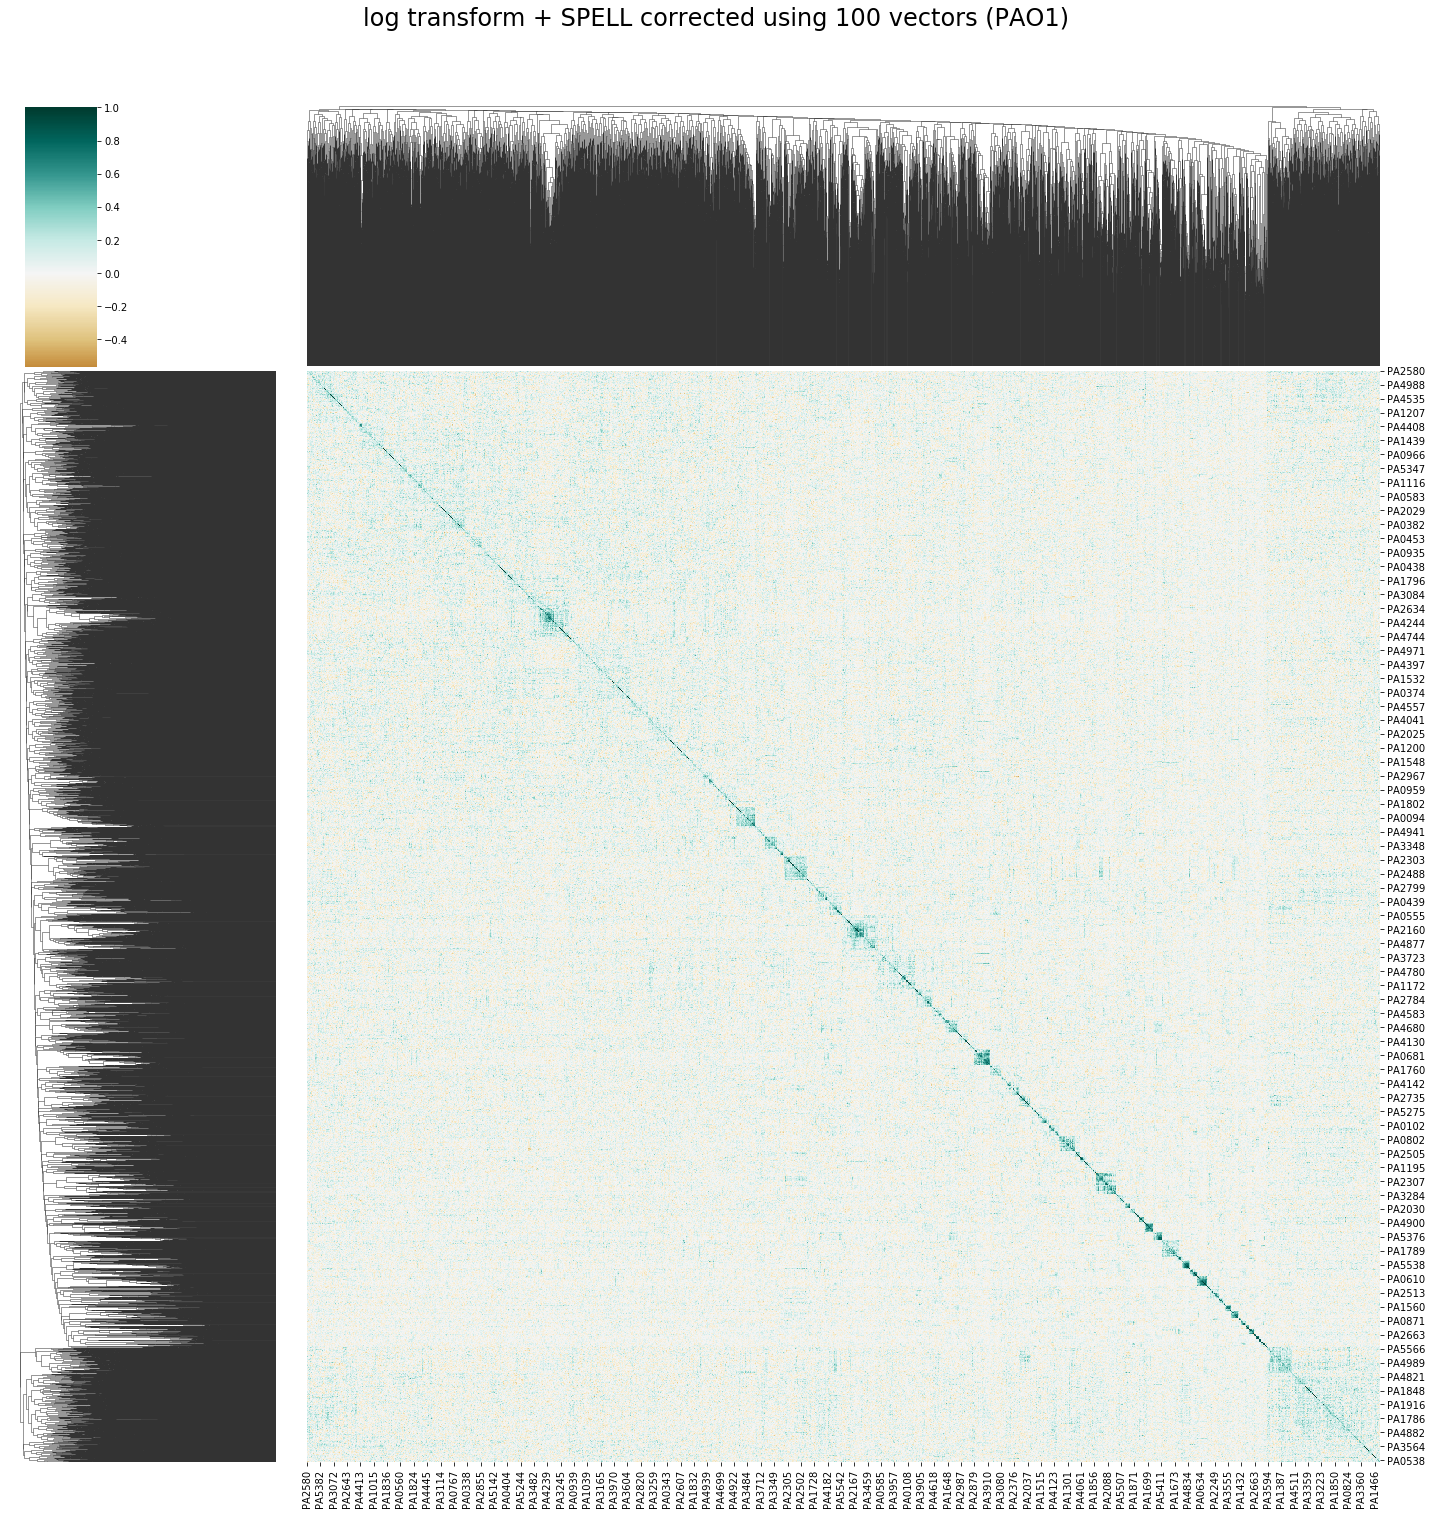

In [21]:
"""%%time
h1a = sns.clustermap(pao1_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))
h1a.fig.suptitle(
    f"log transform + SPELL corrected using {num_SVs} vectors (PAO1)",
    y=1.05,
    fontsize=24,
)

# Save
pao1_log_spell_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_array_log_spell_clustermap.png"
)
h1a.savefig(pao1_log_spell_filename, dpi=300)"""

CPU times: user 2min 57s, sys: 1.53 s, total: 2min 59s
Wall time: 2min 57s


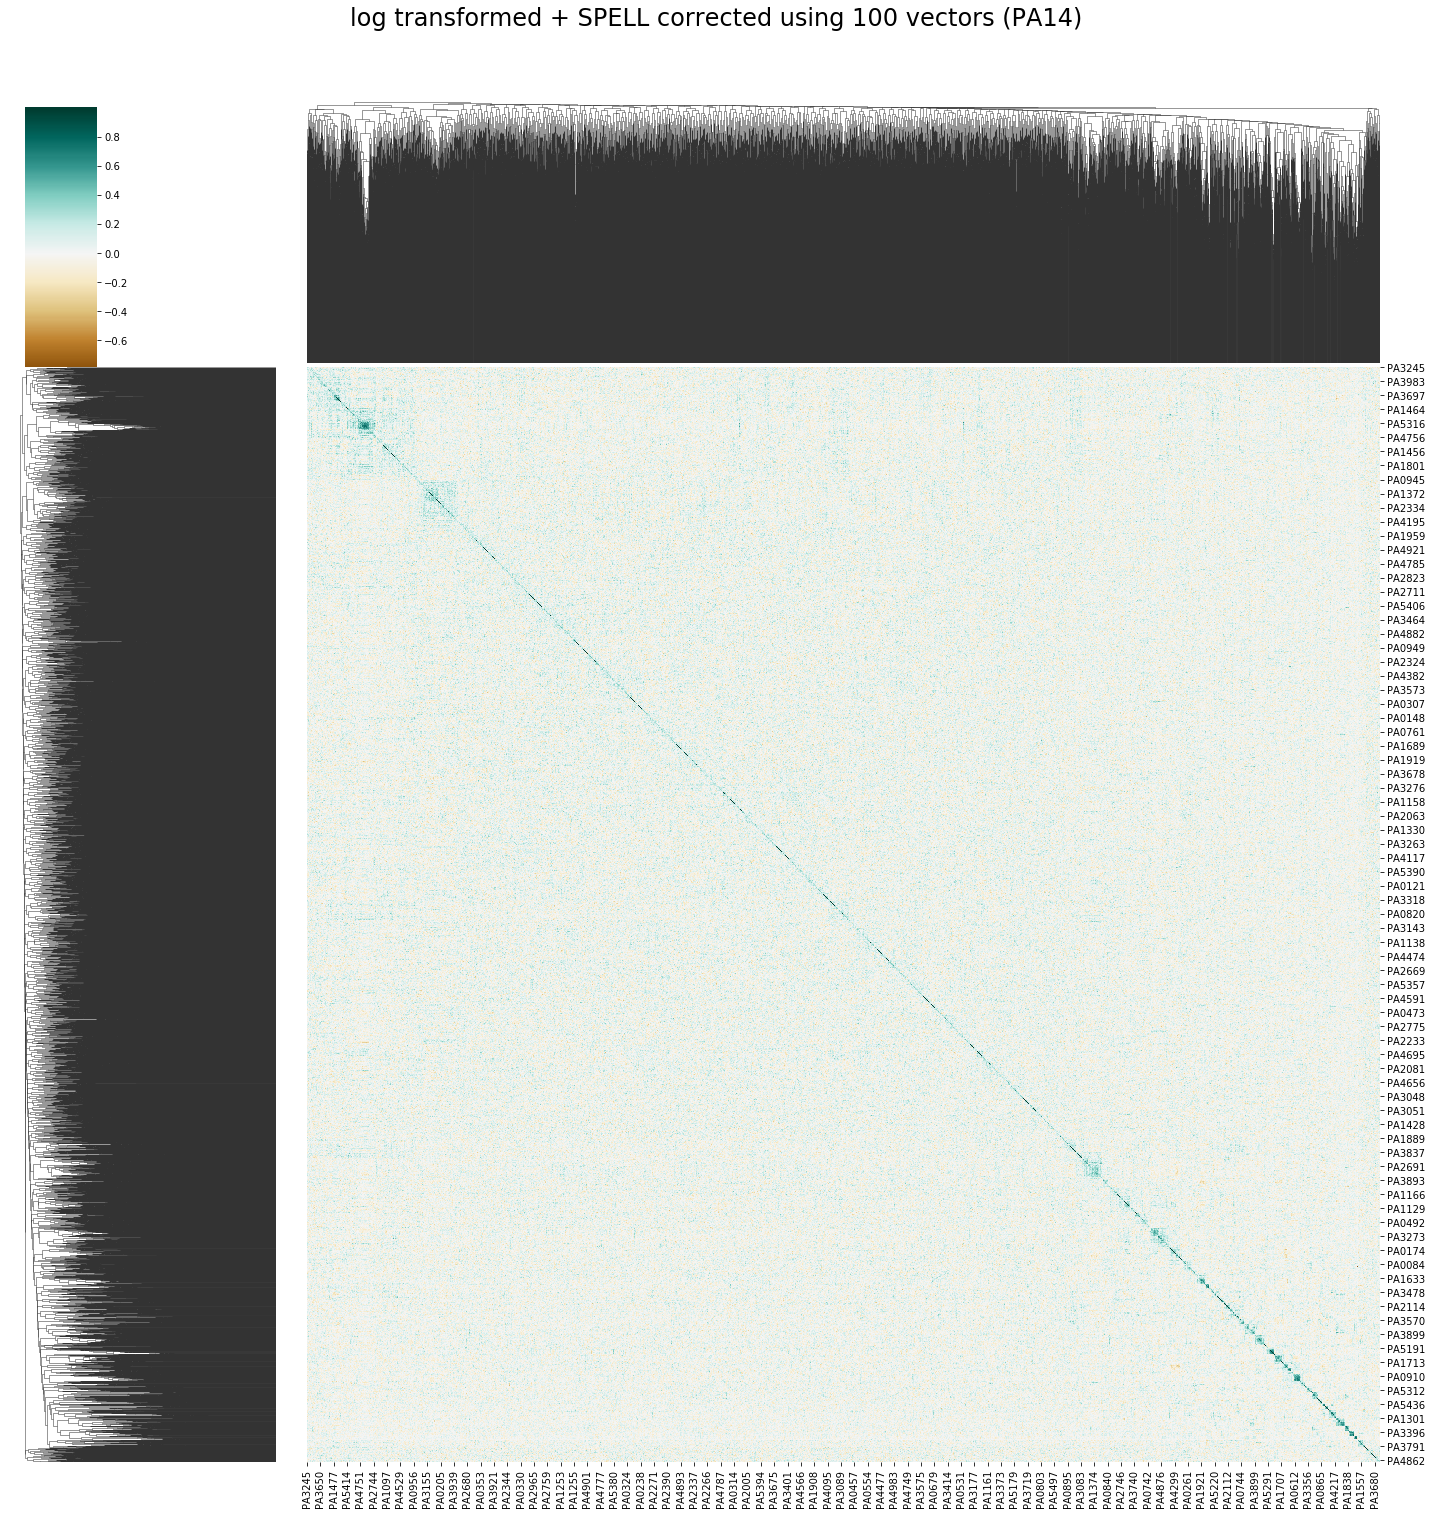

In [22]:
"""%%time
h2a = sns.clustermap(pa14_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))
h2a.fig.suptitle(
    f"log transformed + SPELL corrected using {num_SVs} vectors (PA14)",
    y=1.05,
    fontsize=24,
)

# Save
pa14_log_spell_filename = os.path.join(
    paths.LOCAL_DATA_DIR, "pa14_array_log_spell_clustermap.png"
)
h2a.savefig(pa14_log_spell_filename, dpi=300)"""

## Calculate transcriptional stability

All genes in this array compendium are core genes, since they were selected based on their hybridization so we don't need to map between PAO1 and PA14 ids types like we did for the RNA-seq analysis.

In [23]:
rows = []
for gene_id in array_expression.columns:
    # Make sure that the genes in the correlation profile are in the same order
    # in the PAO1 correlation matrix and the PA14 correlation matrix
    # Otherwise reorder
    if (pao1_corr_log_spell.index.equals(pa14_corr_log_spell.index)) & (
        pao1_corr_log_spell.columns.equals(pa14_corr_log_spell.columns)
    ):
        pass
    else:
        print("ordering is not the same, going to reorder...")
        pa14_corr_log_spell = pa14_corr_log_spell.loc[
            pao1_corr_log_spell.index, pao1_corr_log_spell.columns
        ]
    # Get correlation score
    # Make dataframe  with PAO1 id, PA14 homolog, correlation score
    corr_coef, pval = scipy.stats.pearsonr(
        pao1_corr_log_spell[gene_id], pa14_corr_log_spell[gene_id]
    )

    rows.append(
        {
            "PAO1 id": gene_id,
            "Transcriptional similarity across strains": corr_coef,
            "P-value": pval,
        }
    )

corr_summary_df = pd.DataFrame(rows)

In [24]:
corr_summary_df.set_index("PAO1 id", inplace=True)

In [25]:
print(corr_summary_df.shape)
corr_summary_df.head()

(5549, 2)


Transcriptional similarity across strains       P-value
PAO1 id                                                         
PA0001                                    0.187331  5.318714e-45
PA0002                                    0.247363  3.813672e-78
PA0003                                    0.193869  3.941478e-48
PA0004                                    0.275430  3.634364e-97
PA0005                                    0.100344  6.780602e-14

## Plots

In [26]:
# Add label for most and least stable genes
corr_summary_df["label"] = ""

In [27]:
# Add label for most and least stable genes based on top X%
array_most_stable = corr_summary_df.sort_values(
    "Transcriptional similarity across strains", ascending=False
).head(round(most_percent * len(corr_summary_df)))
array_least_stable = corr_summary_df.sort_values(
    "Transcriptional similarity across strains", ascending=False
).tail(round(least_percent * len(corr_summary_df)))

In [28]:
array_most_threshold = array_most_stable.iloc[-1][
    "Transcriptional similarity across strains"
]
array_least_threshold = array_least_stable.iloc[0][
    "Transcriptional similarity across strains"
]
print(array_least_threshold, array_most_threshold)

0.0849736657127878 0.3078755578830622


In [29]:
corr_summary_df.loc[array_most_stable.index, "label"] = "most stable"
corr_summary_df.loc[array_least_stable.index, "label"] = "least stable"

Text(12.627994791666666, 0.5, 'Count')

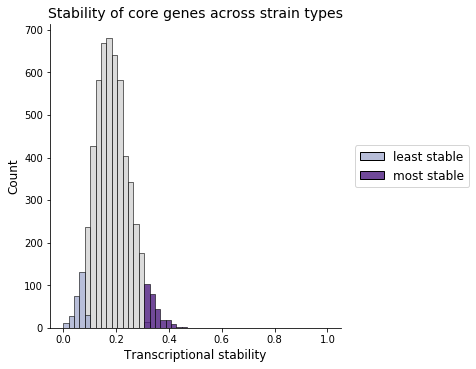

In [30]:
# Plot distribution of correlation scores
# This scores indicate how transcriptionally similar genes are across PAO1 and PA14 strains
fig_array = sns.displot(
    data=corr_summary_df,
    x="Transcriptional similarity across strains",
    hue="label",
    hue_order=["least stable", "most stable", ""],
    # label=["", "least stable", "most stable"],
    palette={"": "lightgrey", "least stable": "#a6aed0ff", "most stable": "#4e1c80"},
    legend=True,
    alpha=0.8,
    bins=np.linspace(0, 1, 50),
)
fig_array._legend.remove()

old_legend = fig_array._legend
handles = old_legend.legendHandles

legend = plt.legend(
    handles=[handles[0], handles[1]],
    labels=[
        fig_array._legend.texts[0].get_text(),
        fig_array._legend.texts[1].get_text(),
    ],
    bbox_to_anchor=(1.05, 0.6),
    loc="upper left",
    borderaxespad=0,
    fontsize=12,
)

plt.title("Stability of core genes across strain types", fontsize=14, y=1.1)
plt.xlabel("Transcriptional stability", fontsize=12)
plt.ylabel("Count", fontsize=12)

## Compare most stable core genes

We want to compare the most stable core genes obtained using the P. aeruginosa RNA-seq compendium vs the array compendium to validate our findings are robust.

In [31]:
# Read in RNA-seq transcriptional statistics
pao1_similarity_scores_filename = "pao1_core_similarity_associations_final_spell.tsv"

pao1_rnaseq_similarity_scores = pd.read_csv(
    pao1_similarity_scores_filename, sep="\t", header=0, index_col=0
)

In [32]:
# Check overlap of gene ids using in RNA-seq vs array compendia
print(len(pao1_rnaseq_similarity_scores.index))
print(len(corr_summary_df.index))

shared_core_genes = set(pao1_rnaseq_similarity_scores.index).intersection(
    corr_summary_df.index
)
print(len(shared_core_genes))

5349
5549
5339


In [33]:
# Select only those shared genes first
pao1_rnaseq_similarity_scores_subset = pao1_rnaseq_similarity_scores.loc[
    shared_core_genes
]
corr_summary_subset_df = corr_summary_df.loc[shared_core_genes]

In [34]:
# Get most and least stable core genes
rnaseq_most_stable_genes = list(
    pao1_rnaseq_similarity_scores_subset[
        pao1_rnaseq_similarity_scores_subset["label"] == "most stable"
    ].index
)
rnaseq_least_stable_genes = list(
    pao1_rnaseq_similarity_scores_subset[
        pao1_rnaseq_similarity_scores_subset["label"] == "least stable"
    ].index
)

array_most_stable_genes = list(
    corr_summary_subset_df[corr_summary_subset_df["label"] == "most stable"].index
)
array_least_stable_genes = list(
    corr_summary_subset_df[corr_summary_subset_df["label"] == "least stable"].index
)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


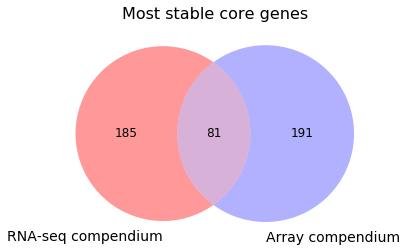

In [35]:
# Compare
most_stable_venn = venn2(
    [set(rnaseq_most_stable_genes), set(array_most_stable_genes)],
    set_labels=("RNA-seq compendium", "Array compendium"),
)

most_stable_venn.get_patch_by_id("11").set_color("purple")
most_stable_venn.get_patch_by_id("11").set_edgecolor("none")
most_stable_venn.get_patch_by_id("11").set_alpha(0.3)
most_stable_venn.get_patch_by_id("01").set_color("blue")
most_stable_venn.get_patch_by_id("01").set_edgecolor("none")
most_stable_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("Most stable core genes", fontsize=16, fontname="Verdana")
for text in most_stable_venn.set_labels:
    text.set_fontsize(14)
    text.set_fontname("Verdana")

for text in most_stable_venn.subset_labels:
    text.set_fontsize(12)
    text.set_fontname("Verdana")

# Save figure
plt.savefig(
    "most_stable_array_vs_rnaseq_venn.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

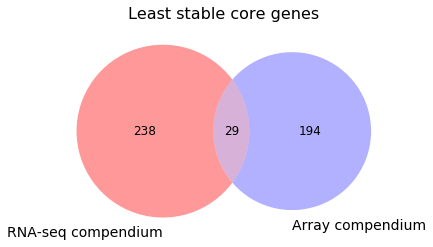

In [36]:
least_stable_venn = venn2(
    [set(rnaseq_least_stable_genes), set(array_least_stable_genes)],
    set_labels=("RNA-seq compendium", "Array compendium"),
)

least_stable_venn.get_patch_by_id("11").set_color("purple")
least_stable_venn.get_patch_by_id("11").set_edgecolor("none")
least_stable_venn.get_patch_by_id("11").set_alpha(0.3)
least_stable_venn.get_patch_by_id("01").set_color("blue")
least_stable_venn.get_patch_by_id("01").set_edgecolor("none")
least_stable_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("Least stable core genes", fontsize=16, fontname="Verdana")
for text in least_stable_venn.set_labels:
    text.set_fontsize(14)
    text.set_fontname("Verdana")

for text in least_stable_venn.subset_labels:
    text.set_fontsize(12)
    text.set_fontname("Verdana")


# Save figure
plt.savefig(
    "least_stable_array_vs_rnaseq_venn",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

## Examine genes that differ

In [37]:
most_rnaseq_only = set(rnaseq_most_stable_genes).difference(array_most_stable_genes)
most_array_only = set(array_most_stable_genes).difference(rnaseq_most_stable_genes)

least_rnaseq_only = set(rnaseq_least_stable_genes).difference(array_least_stable_genes)
least_array_only = set(array_least_stable_genes).difference(rnaseq_least_stable_genes)

In [38]:
pao1_rnaseq_similarity_scores_subset.loc[most_rnaseq_only]

PA14 homolog id  Transcriptional similarity across strains  P-value  \
PAO1 id                                                                       
PA3168       PA14_23260                                   0.664126      0.0   
PA5207       PA14_68780                                   0.603226      0.0   
PA5565       PA14_73370                                   0.571783      0.0   
PA4997       PA14_66080                                   0.617545      0.0   
PA4488       PA14_58240                                   0.566873      0.0   
...                 ...                                        ...      ...   
PA5201       PA14_68710                                   0.559510      0.0   
PA3742       PA14_16000                                   0.603267      0.0   
PA3108       PA14_23920                                   0.565147      0.0   
PA4750       PA14_62850                                   0.582092      0.0   
PA5568       PA14_73410                                   0.617898      0.0   

         Name        label  mean expression  standard deviation expression  \
PAO1 id                                                                      
PA3168   gyrA  most stable      3603.506234                    1335.017534   
PA5207    NaN  most stable       276.987099                     254.813781   
PA5565   gidA  most stable      1610.011756                     757.875788   
PA4997   msbA  most stable      1124.392629                     638.476376   
PA4488   magE  most stable       504.804251                     410.870478   
...       ...          ...              ...                            ...   
PA5201    NaN  most stable       924.718780                     566.757266   
PA3742   rplS  most stable      3315.524517                    5049.187028   
PA3108   purF  most stable      1407.779315                     733.040664   
PA4750   folP  most stable       781.478626                     577.528140   
PA5568    NaN  most stable      2115.855294                    1681.114405   

         min expression  25% expression  50% expression  75% expression  \
PAO1 id                                                                   
PA3168      1177.708300     2709.753545     3457.655402     4249.897249   
PA5207         7.750929      100.051706      206.786512      378.076132   
PA5565       428.213763     1095.536785     1472.604787     1916.216049   
PA4997       225.874292      744.918694      987.863134     1332.702504   
PA4488         8.137191      234.527635      383.090367      644.940944   
...                 ...             ...             ...             ...   
PA5201       116.280774      542.246540      792.847910     1162.564480   
PA3742        99.847664      804.843738     2006.667764     3915.734517   
PA3108       446.321949      994.450184     1280.548661     1622.992092   
PA4750         3.440431      459.594314      636.232487      932.716494   
PA5568       211.551371     1079.411117     1741.588377     2594.389871   

         max expression  variance expression  range expression  \
PAO1 id                                                          
PA3168     14034.165360         1.782272e+06      12856.457059   
PA5207      2298.888522         6.493006e+04       2291.137592   
PA5565      7120.473866         5.743757e+05       6692.260103   
PA4997      7515.186107         4.076521e+05       7289.311815   
PA4488      2987.660270         1.688145e+05       2979.523079   
...                 ...                  ...               ...   
PA5201      5008.007400         3.212138e+05       4891.726626   
PA3742     59554.611806         2.549429e+07      59454.764142   
PA3108      9108.853380         5.373486e+05       8662.531431   
PA4750      8118.818750         3.335388e+05       8115.378319   
PA5568     22279.509913         2.826146e+06      22067.958542   

                                          pathways present Related acc genes  
PAO1 id                                            

In [39]:
pao1_rnaseq_similarity_scores_subset.loc[most_array_only]

PA14 homolog id  Transcriptional similarity across strains  \
PAO1 id                                                              
PA0905       PA14_52570                                   0.412288   
PA0760       PA14_54470                                   0.405524   
PA0631       PA14_08190                                   0.343061   
PA1709       PA14_42440                                   0.493958   
PA5300       PA14_69970                                   0.526915   
...                 ...                                        ...   
PA4648       PA14_61500                                   0.340883   
PA2069       PA14_37745                                   0.410783   
PA0781       PA14_54180                                   0.312482   
PA0985       PA14_59220                                   0.276810   
PA2389       PA14_33770                                   0.346546   

               P-value   Name label  mean expression  \
PAO1 id                                                
PA0905   1.270681e-218   rsmA   NaN      6375.185829   
PA0760   6.649779e-211    NaN   NaN       177.860182   
PA0631   1.315083e-147    NaN   NaN       107.194859   
PA1709    0.000000e+00   popD   NaN       478.156592   
PA5300    0.000000e+00   cycB   NaN      1442.737361   
...                ...    ...   ...              ...   
PA4648   1.204586e-145  cupE1   NaN       255.558159   
PA2069   6.868984e-217    NaN   NaN       938.707681   
PA0781   1.752560e-121    NaN   NaN       579.253225   
PA0985    1.083810e-94  pyoS5   NaN       870.772613   
PA2389   8.873456e-151   pvdR   NaN       330.859453   

         standard deviation expression  min expression  25% expression  \
PAO1 id                                                                  
PA0905                    20130.563520       27.849066      707.481632   
PA0760                      128.550055        0.000000       90.410761   
PA0631                      232.511722        0.000000       16.291035   
PA1709                     1266.680835        0.000000       58.366124   
PA5300                     2187.002499       15.766655      474.893739   
...                                ...             ...             ...   
PA4648                      563.436549        0.000000       19.324801   
PA2069                     1829.996241        0.000000       23.572308   
PA0781                     1899.159174        0.000000       25.075436   
PA0985                     2000.601438        0.000000      113.790550   
PA2389                      647.949421        0.000000       54.319029   

         50% expression  75% expression  max expression  variance expression  \
PAO1 id                                                                        
PA0905      1686.795739     3770.761931   259511.639109         4.052396e+08   
PA0760       141.944492      218.043068      855.737189         1.652512e+04   
PA0631        39.470736       93.559861     2923.430576         5.406170e+04   
PA1709       143.769042      298.293319    13406.132429         1.604480e+06   
PA5300       866.502211     1584.897415    25689.719168         4.782980e+06   
...                 ...             ...             ...                  ...   
PA4648        67.348584      301.510757     8533.107149         3.174607e+05   
PA2069       118.915250      851.669006    12597.251412         3.348886e+06   
PA0781        55.730222      209.572816    19467.965634         3.606806e+06   
PA0985       283.431397      756.430654    20728.435477         4.002406e+06   
PA2389       106.660990      315.133057     9022.432389         4.198385e+05   

         range expression pathways present Related acc genes  
PAO1 id                                                       
PA0905      259483.790043               []               NaN  
PA0760         855.737189               []               NaN  
PA0631        2923.430576               []               NaN  
PA1709       13406.132429               []       

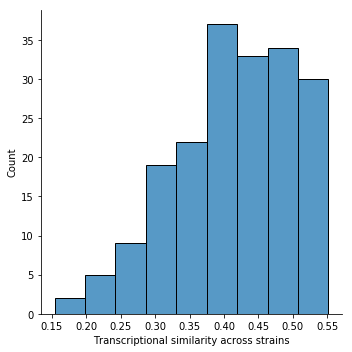

In [40]:
sns.displot(
    pao1_rnaseq_similarity_scores_subset.loc[
        most_array_only, "Transcriptional similarity across strains"
    ]
)

In [41]:
pao1_rnaseq_similarity_scores_subset.loc[least_rnaseq_only]

PA14 homolog id  Transcriptional similarity across strains  \
PAO1 id                                                              
PA0349       PA14_04570                                   0.095440   
PA2037       PA14_38180                                   0.073949   
PA3867       PA14_15430                                  -0.023794   
PA1265       PA14_47870                                   0.111040   
PA1933       PA14_39520                                   0.095978   
...                 ...                                        ...   
PA0982       PA14_59960                                   0.089992   
PA2650       PA14_29830                                   0.119833   
PA2590       PA14_30590                                   0.127542   
PA0880       PA14_52890                                   0.115206   
PA2208       PA14_36150                                   0.123409   

              P-value Name         label  mean expression  \
PAO1 id                                                     
PA0349   2.661168e-12  NaN  least stable        85.631779   
PA2037   6.143897e-08  NaN  least stable       482.819125   
PA3867   8.184794e-02  NaN  least stable        96.921647   
PA1265   3.810769e-16  NaN  least stable        45.829638   
PA1933   2.004979e-12  NaN  least stable       702.506962   
...               ...  ...           ...              ...   
PA0982   4.293132e-11  NaN  least stable       246.931340   
PA2650   1.445108e-18  NaN  least stable        71.535182   
PA2590   7.667873e-21  NaN  least stable       166.639832   
PA0880   2.862912e-17  NaN  least stable        24.651990   
PA2208   1.325115e-19  NaN  least stable        20.798142   

         standard deviation expression  min expression  25% expression  \
PAO1 id                                                                  
PA0349                      144.081830             0.0       16.289911   
PA2037                     2072.058767             0.0       60.679260   
PA3867                      181.134863             0.0       30.230765   
PA1265                      120.181473             0.0        3.923411   
PA1933                     1056.414411             0.0       97.509359   
...                                ...             ...             ...   
PA0982                      264.503757             0.0       93.107647   
PA2650                       84.322623             0.0       27.861632   
PA2590                      239.271216             0.0       36.513579   
PA0880                       48.242327             0.0        1.624948   
PA2208                       43.061533             0.0        1.392899   

         50% expression  75% expression  max expression  variance expression  \
PAO1 id                                                                        
PA0349        34.546157       74.932393     1251.158269         2.075957e+04   
PA2037       145.329153      280.257591    29356.943160         4.293428e+06   
PA3867        58.730950       99.229836     2453.773482         3.280984e+04   
PA1265        11.040555       31.978219     2272.012172         1.444359e+04   
PA1933       311.660634      921.187651    10546.971375         1.116011e+06   
...                 ...             ...             ...                  ...   
PA0982       167.842025      289.462836     2507.552922         6.996224e+04   
PA2650        47.644547       77.051932      597.031093         7.110305e+03   
PA2590        70.927502      169.789893     1489.848328         5.725071e+04   
PA0880         4.581626       18.244660      466.715054         2.327322e+03   
PA2208         5.143613       15.200744      296.237807         1.854296e+03   

         range expression                              pathways present  \
PAO1 id                                                                   
PA0349        1251.158269                                            []   
PA2037       29356.943160                                            []   

In [42]:
pao1_rnaseq_similarity_scores_subset.loc[least_array_only]

PA14 homolog id  Transcriptional similarity across strains  \
PAO1 id                                                              
PA1630       PA14_43430                                   0.317718   
PA3469       PA14_19210                                   0.238619   
PA4827       PA14_63830                                   0.258754   
PA4969       PA14_65690                                   0.357207   
PA0677       PA14_55530                                   0.149556   
...                 ...                                        ...   
PA2492       PA14_32410                                   0.196522   
PA2457       PA14_20510                                   0.180168   
PA1563       PA14_44280                                   0.372744   
PA0728       PA14_48880                                   0.177234   
PA0723       PA14_48940                                   0.182304   

               P-value  Name label  mean expression  \
PAO1 id                                               
PA1630   9.616518e-126   NaN   NaN       208.891748   
PA3469    3.897196e-70   NaN   NaN       130.063457   
PA4827    1.446207e-82   NaN   NaN       129.895964   
PA4969   9.813648e-161  cpdA   NaN       260.043784   
PA0677    3.934320e-28  hxcW   NaN        38.865519   
...                ...   ...   ...              ...   
PA2492    1.026662e-47  mexT   NaN       329.188813   
PA2457    2.918507e-40   NaN   NaN       182.521891   
PA1563   6.025714e-176   NaN   NaN       228.466015   
PA0728    5.368918e-39   NaN   NaN       174.954215   
PA0723    3.391032e-41  coaB   NaN      5269.792480   

         standard deviation expression  min expression  25% expression  \
PAO1 id                                                                  
PA1630                      282.078146        0.000000       90.463534   
PA3469                       62.081548        0.000000       88.190855   
PA4827                       86.220460        0.000000       68.344215   
PA4969                      157.144227        0.000000      147.059127   
PA0677                       80.314912        0.000000        3.037909   
...                                ...             ...             ...   
PA2492                      297.347852        0.000000      169.812462   
PA2457                      357.590795        0.000000       41.377450   
PA1563                      127.487855       18.300332      146.981938   
PA0728                     1367.541073        0.000000       22.139639   
PA0723                    51792.378047        0.000000       76.265072   

         50% expression  75% expression  max expression  variance expression  \
PAO1 id                                                                        
PA1630       132.781178      230.864801     4238.701319         7.956808e+04   
PA3469       118.234345      158.768137      497.859377         3.854119e+03   
PA4827       111.689675      162.427637      651.786180         7.433968e+03   
PA4969       232.895890      330.648041     1194.476955         2.469431e+04   
PA0677         8.790180       29.047666      599.562498         6.450485e+03   
...                 ...             ...             ...                  ...   
PA2492       278.549584      424.947052     4227.238940         8.841575e+04   
PA2457        79.165891      168.124290     4601.359613         1.278712e+05   
PA1563       199.261705      275.863463     1239.973422         1.625315e+04   
PA0728        41.856357       66.131639    25925.138062         1.870169e+06   
PA0723       153.502494      333.146150   962018.330814         2.682450e+09   

         range expression                                   pathways present  \
PAO1 id                                                                        
PA1630        4238.701319                                                 []   
PA3469         497.859377                                                 []   
PA4827         651.786180                                

In [43]:
# Save
fig_array.savefig(
    array_similarity_dist_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**
* Venn diagram comparing the most stable core genes using the array vs RNA-seq compendium, where the most stable genes = top 5% of genes with the highest transcriptional similarity.
* There is some consistency of most stable genes using the array and RNA-seq compendia
* Looking at the RNA-seq transcriptional similarity of the array only genes (191 genes), most of these genes were just below the threshold for "most stable" (transcriptional similarity = 0.4 - 0.55) according to the distribution plot. However there are some genes that have a lower similarity score (0.2 - 0.3). Why are these stable in microarray but not RNA-seq?

* I also plotted the results comparing the least stable genes across the compendium, but its less clear what this is telling us since these genes are those that have unstable profiles across strains.

In [44]:
# Save transcriptional similarity df
corr_summary_df.to_csv(array_similarity_scores_filename, sep="\t")